In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from surprise import Dataset, Reader, accuracy , KNNWithMeans
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from surprise.prediction_algorithms import SVD, SVDpp, NormalPredictor , BaselineOnly

plt.style.use('fast')
%matplotlib inline

In [2]:
music_review2=pd.read_csv('./Data/music_review.csv')

In [3]:
music_review2.asin.nunique()

456811

In [4]:
music_review2.reviewerID.nunique()

839565

In [5]:
music_review2.isna().sum()

Unnamed: 0    0
overall       0
reviewerID    0
asin          0
reviewText    5
dtype: int64

In [6]:
music_review2=music_review2.drop('Unnamed: 0' , axis=1 )

In [7]:
music_review2.dropna(inplace=True)

grouby by asin and join review text 

In [8]:
music_review2.head()

,overall,reviewerID,asin,reviewText
0,5,A1ZCPG3D3HGRSS,0001388703,This is a great cd full of worship favorites!!...
1,5,AC2PL52NKPL29,0001388703,"So creative! Love his music - the words, the ..."
2,5,A1SUZXBDZSDQ3A,0001388703,"Keith Green, gone far to early in his carreer,..."
3,5,A3A0W7FZXM0IZW,0001388703,Keith Green had his special comedy style of Ch...
4,5,A12R54MKO17TW0,0001388703,Keith Green / So you wanna go back to Egypt......


In [9]:
music_review2.reviewerID.value_counts()

A3W4D8XOGLWUN5    1255
AQ4B80F0JSBNI      660
A1Q0BU32CVOLRA     638
A2WQY1B8ZS7QRZ     534
A2H3JURQZOHVMB     484
                  ... 
A11EXV6QKT9MYQ       1
A1E43Z3QQ79OKY       1
A38J3EZKMXZ9YZ       1
A2G4LKK57XMBL3       1
A1EKQAPCF8HOLL       1
Name: reviewerID, Length: 839565, dtype: int64

In [10]:
# Count the occurrences of each reviewer ID
reviewer_counts = music_review2['reviewerID'].value_counts()

# Find reviewer IDs with count equals to 1
reviewer_ids_to_drop = reviewer_counts[reviewer_counts == 1].index

# Drop rows where reviewer ID is in the list of IDs to drop
music_review2 = music_review2[~music_review2['reviewerID'].isin(reviewer_ids_to_drop)]


In [11]:
music_review2.asin.value_counts()

B00CZF8B68    1661
B00M8JCW3E     865
B00NPZI1ZS     767
B00BWGHIHY     762
B0092MKTL2     746
              ... 
B00123JIJS       1
B019D5XRWA       1
B00B6CE2L4       1
B00OV439F4       1
B00Q3800JY       1
Name: asin, Length: 333636, dtype: int64

In [12]:
# Count the occurrences of each reviewer ID
asin_counts = music_review2['asin'].value_counts()

# Find reviewer IDs with count equals to 1
asin_to_drop = asin_counts[asin_counts == 1].index

# Drop rows where reviewer ID is in the list of IDs to drop
music_review2 = music_review2[~music_review2['reviewerID'].isin(reviewer_ids_to_drop)]

normalize the rating ,cause i have 5 only 

<AxesSubplot:xlabel='overall', ylabel='Count'>

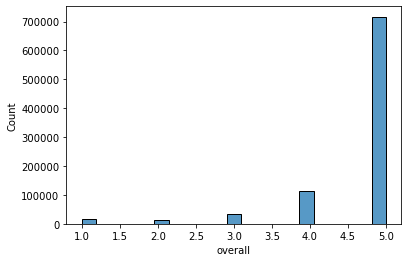

In [13]:
sns.histplot(music_review2.overall)

normalize review

In [14]:
music_review2.columns

Index(['overall', 'reviewerID', 'asin', 'reviewText'], dtype='object')

In [15]:
music_review2.isna().sum()

overall       0
reviewerID    0
asin          0
reviewText    0
dtype: int64

In [16]:
# Convert 'overall' column to integers
music_review2['overall'] = music_review2['overall'].astype(int)

# Calculate average rating for each reviewer
reviewer_avg_ratings = music_review2.groupby('reviewerID')['overall'].mean().reset_index()

# Merge the average ratings back into the DataFrame
music_review2 = music_review2.merge(reviewer_avg_ratings, on='reviewerID', suffixes=('', '_avg'))

# Subtract average rating from each rating
music_review2['normalized_rating'] = music_review2['overall'] - music_review2['overall_avg']

In [17]:
music_review2.normalized_rating.min(),music_review2.normalized_rating.max()

(-3.973140495867769, 3.891891891891892)

First_simple_Modeling

In [58]:
def calculate_average_rmse(model, music_review):
    # Perform cross-validation
    results = cross_validate(model, music_review, measures=['RMSE'], cv=3, n_jobs=-1, verbose=True)
    
    # Average RMSE
    average_rmse = round(sum(results["test_rmse"]) / len(results["test_rmse"]), 3)
    return average_rmse

NoramlPredictor

In [18]:
reader = Reader(rating_scale=(-3.973140495867769, 3.891891891891892))
music_review = Dataset.load_from_df(music_review2[['reviewerID', 'asin', 'normalized_rating']], reader)

trainset, testset = train_test_split(music_review, test_size=0.2, random_state=42)


In [59]:
NP= NormalPredictor()
NP.fit(trainset)

# Return test predictions for model fit on trainset
predictions = NP.test(testset)

# Average RMSE
average_rmse_NP = calculate_average_rmse(NP, music_review)

print(f'Average RMSE from cross-validation is : {average_rmse_NP}')


Evaluating RMSE of algorithm NormalPredictor on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.7864  0.7872  0.7868  0.7868  0.0003  
Fit time          0.94    0.97    0.85    0.92    0.05    
Test time         2.91    2.72    2.47    2.70    0.18    


baseline only

In [60]:
# Instantiate and fit model
baseline = BaselineOnly()
baseline.fit(trainset)

# Return test predictions for model fit on trainset
predictions = baseline.test(testset)

# Average RMSE
average_rmse_BL = calculate_average_rmse(baseline, music_review)
print(f'Average RMSE from cross-validation is : {average_rmse_BL}')

Estimating biases using als...
Evaluating RMSE of algorithm BaselineOnly on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.5704  0.5692  0.5729  0.5708  0.0016  
Fit time          2.04    2.10    1.99    2.04    0.04    
Test time         2.78    2.63    2.29    2.56    0.21    
Average RMSE from cross-validation is : 0.571


SVD

In [61]:
# Create a basic SVD model with a specified random state
svd_basic = SVD(random_state=42)

# Fit the basic SVD model to the training set
svd_basic.fit(trainset)
predictions = svd_basic.test(testset)

# Calculate the RMSE for the predictions and store it in svd_simple
svd_simple = accuracy.rmse(predictions)

# Calculate the average RMSE across all folds using the calculate_average_rmse function
average_rmse_SVD1 = calculate_average_rmse(svd_basic, music_review)
print(f'Average RMSE from cross-validation is : {average_rmse_SVD1}')

RMSE: 0.5897
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.5846  0.5827  0.5857  0.5843  0.0012  
Fit time          45.07   45.49   46.62   45.73   0.65    
Test time         3.45    3.50    2.98    3.31    0.24    
Average RMSE from cross-validation is : 0.584


SVD grid search

dont run this

In [23]:
# # Define a range of hyperparameters for GridSearchCV with SVD++
# param_grid = {
#     'n_factors': [50, 100, 150],  # Number of factors
#     'n_epochs': [20, 30],  # Number of epochs
#     'lr_all': [0.005, 0.01],  # Learning rate
#     'reg_all': [0.02, 0.1]  # Regularization term
# }

# # Setup GridSearchCV with SVD++
# gs_svd = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# # Fit the model
# gs_svd.fit(music_review)

# # Best score and parameters
# best_rmse = gs_svd.best_score['rmse']
# best_params = gs_svd.best_params['rmse']

# print(f"Best RMSE: {best_rmse}")
# print(f"Best parameters: {best_params}")


Best RMSE: 1.0993641323939394

Best parameters: {'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}

In [62]:
# Define a more complex SVD model with specified parameters
SVD_2 = SVD(n_factors=50, n_epochs=30, lr_all=0.01, reg_all=0.1, random_state=42)

# Fit the more complex SVD model to the training set
SVD_2.fit(trainset)
predictions = SVD_2.test(testset)

# Calculate the RMSE for the predictions and store it in svd_simple
svd_simple = accuracy.rmse(predictions)

# Calculate the average RMSE across all folds using the calculate_average_rmse function
average_rmse_SVD2 = calculate_average_rmse(SVD_2, music_review)
print(f'Average RMSE from cross-validation is : {average_rmse_SVD2}')

RMSE: 0.6198
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.6119  0.6135  0.6124  0.6126  0.0007  
Fit time          46.59   46.85   47.44   46.96   0.36    
Test time         3.34    3.28    2.67    3.10    0.31    
Average RMSE from cross-validation is : 0.613


second gride search

In [26]:
# # Setup new hyperparameter dictionary
# svd_param_grid2 = {'n_factors':[5, 20],
#                   'n_epochs': [20, 40], 
#                   'lr_all': [0.05, .005],
#                   'reg_all': [0.01, 0.02]}
# svd_gr_3 = GridSearchCV(SVD,param_grid=svd_param_grid2,joblib_verbose=10, n_jobs=-1, cv=3)

# # Return best_params based on RMSE
# svd_gr_3 .fit(music_review)
# svd_gr_3 .best_params['rmse']

{'n_factors': 5, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02}

In [64]:
# Define SVD model with specified parameters
SVD_3 = SVD(n_factors=5, n_epochs=20, lr_all=0.005, reg_all=0.02, random_state=42)

# Fit the SVD model to the training set
SVD_3.fit(trainset)
predictions = SVD_3.test(testset)

# Calculate the RMSE for the predictions and store it in svd_simple_3
svd_simple_3 = accuracy.rmse(predictions)

# Calculate the average RMSE across all folds using the calculate_average_rmse function
average_rmse_SVD3 = calculate_average_rmse(SVD_3, music_review)
print(f'Average RMSE from cross-validation is : {average_rmse_SVD3}')


RMSE: 0.5871
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.5814  0.5812  0.5833  0.5820  0.0009  
Fit time          13.12   12.65   12.72   12.83   0.21    
Test time         2.98    3.02    2.67    2.89    0.16    
Average RMSE from cross-validation is : 0.582


SVD++

In [29]:
# Instantiate - fit on trainset - score the model on testset
SVDpp_basic= SVDpp(n_factors=1, n_epochs=25, random_state=42, reg_all=0.05)
SVDpp_basic.fit(trainset)
predictions = SVDpp_basic.test(testset)
SVDpp_gs = accuracy.rmse(predictions)

RMSE: 0.6042


svd ++ gride search

In [35]:
# param_grid = {'n_factors':[1, 5],
#                     'n_epochs':[25, 50],
#                     'reg_all':[0.02, 0.05]}

# # Setup GridSearchCV with SVD++
# gs_svdpp = GridSearchCV(SVDpp, param_grid, cv=3, joblib_verbose=10, n_jobs=-1, return_train_measures=True)


# # Return best_params based on RMSE
# gs_svdpp .fit(music_review)
# gs_svdpp .best_params['rmse']

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done  12 out of  24 | elapsed: 26.0min remaining: 26.0min
[Parallel(n_jobs=-1)]: Done  15 out of  24 | elapsed: 27.2min remaining: 16.3min
[Parallel(n_jobs=-1)]: Done  18 out of  24 | elapsed: 29.7min remaining:  9.9min
[Parallel(n_jobs=-1)]: Done  21 out of  24 | elapsed: 41.3min remaining:  5.9min
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 41.7min finished


{'n_factors': 5, 'n_epochs': 25, 'reg_all': 0.05}

In [36]:
SVDpp_2= SVDpp(n_factors=5, n_epochs=25, random_state=42, reg_all=0.05)
SVDpp_2.fit(trainset)
predictions = SVDpp_2.test(testset)
SVDpp_2_gs = accuracy.rmse(predictions)

RMSE: 0.6040


use - coclustering

In [69]:
from surprise import CoClustering  # Importing the CoClustering algorithm

# Define a CoClustering model with specified parameters
co_clustering = CoClustering(n_cltr_u=3, n_cltr_i=3, n_epochs=30, random_state=42)

# Fit the CoClustering model to the training set
co_clustering.fit(trainset)

# Generate predictions on the test set using the CoClustering model
predictions = co_clustering.test(testset)

# Calculate the RMSE for the predictions and store it in co_clustering_simple
co_clustering_simple = accuracy.rmse(predictions)

# Calculate the average RMSE across all folds using the calculate_average_rmse function
average_rmse_co_clustering = calculate_average_rmse(co_clustering, music_review)
print(f'Average RMSE from cross-validation is : {average_rmse_co_clustering}')


RMSE: 0.6855
Evaluating RMSE of algorithm CoClustering on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.6793  0.6704  0.6825  0.6774  0.0051  
Fit time          121.71  123.08  123.33  122.71  0.71    
Test time         3.32    2.87    2.66    2.95    0.27    
Average RMSE from cross-validation is : 0.677


Model Evaluation

In [70]:
results = {
    'NormalPredictor': average_rmse_NP,
    'BaselineOnly': average_rmse_BL,
    'svd_basic': average_rmse_SVD1,
    'SVD_2 ': average_rmse_SVD2,
    'SVD_3':average_rmse_SVD3,
    'SVDpp_basic':SVDpp_gs,
    'SVDpp_2':SVDpp_2_gs, 
    'co_clustering' : average_rmse_co_clustering,
}

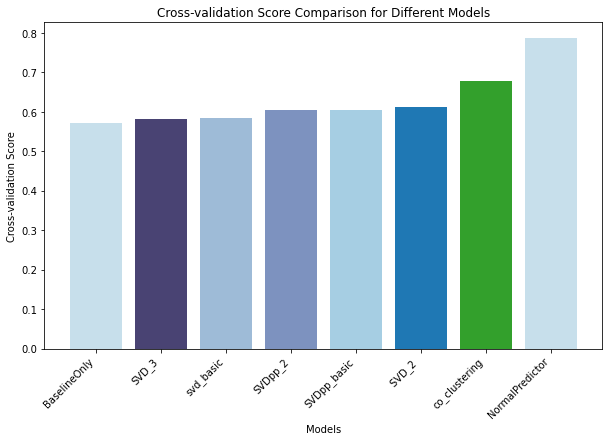

In [71]:
import matplotlib.pyplot as plt

# Sort results based on values
sorted_results = dict(sorted(results.items(), key=lambda item: item[1]))

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#c7dfeb', '#494373', '#9ebbd7', '#7d92bf', '#a6cee3', '#1f78b4', '#33a02c']

plt.bar(sorted_results.keys(), sorted_results.values(), color=colors)

plt.xlabel('Models')
plt.ylabel('Cross-validation Score')
plt.title('Cross-validation Score Comparison for Different Models')
plt.xticks(rotation=45, ha="right")

plt.show()


Recommendation function 

pickle

In [76]:
# Using Surprise, a full trainset incorporating all data can be built
trainset_full = music_review.build_full_trainset()

# Fit the SVD3 model to the full trainset to make full predictions
SVD_3.fit(trainset_full)


In [77]:
model_filename = 'SVD3.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(SVD_3, file)

In [111]:
music_meta = pd.read_csv('./Data/music_meta.csv')
music_meta.drop(columns =['Unnamed: 0'], inplace=True)

In [112]:
music_meta

,description,title,brand,asin,style
0,[],Master Collection Volume One,John Michael Talbot,0001377647,Audio CD
1,[],Hymns Collection: Hymns 1 &amp; 2,Second Chapter of Acts,0001529145,Audio CD
2,[],Early Works - Don Francisco,Don Francisco,0001527134,Audio CD
3,[],So You Wanna Go Back to Egypt,Keith Green,0001388703,Audio CD
4,"[""1. Losing Game 2. I Can't Wait 3. Didn't He ...",Early Works - Dallas Holm,Dallas Holm,0001526146,Audio CD
...,...,...,...,...,...
74342,"['1. ""Free At Last"" Southside 1:21 2. ""Never G...",FUTURE PRESENTS: 56 NIGHTS,FUTURE,B01HH7D5KU,MP3 Music
74343,[],Tori Amos - Little Earthquakes? - Lp Vinyl Record,Tori Amos,B01HHGQXI2,MP3 Music
74344,[],EXO - EX'ACT 3rd Album [Korean Lucky One Versi...,EXO,B01HHRIKKK,MP3 Music
74345,[],Vanilla Fudge (Korea Edition),NaN,B01HI2B3G2,MP3 Music


In [94]:
music_review_fun=music_review2.set_index('reviewerID')
music_review_fun.drop(columns=['overall', 'reviewText', 'overall_avg', 'normalized_rating'], inplace=True)
music_review_fun.head()

,asin
reviewerID,
A12R54MKO17TW0,0001388703
A12R54MKO17TW0,B000VZJS84
A12R54MKO17TW0,B000WLNUN6
A12R54MKO17TW0,B001232RGE
A12R54MKO17TW0,B00123KDR4


In [139]:
def get_recommendations2(user_id, num_recommendations):
    try:
        have_reviewed = list(music_review_fun.loc[user_id, 'asin'])
    except KeyError:
        return "User ID not found or user hasn't reviewed any items."

    not_reviewed = music_meta[~music_meta['asin'].isin(have_reviewed)].copy()
    not_reviewed.reset_index(inplace=True)

    if not_reviewed.empty:
        return "All items have been reviewed by the user."

    # Use loc to avoid SettingWithCopyWarning
    not_reviewed.loc[:, 'est_rating'] = not_reviewed['asin'].apply(lambda x: SVD_3.predict(user_id, x).est)
    not_reviewed.sort_values(by='est_rating', ascending=False, inplace=True)

    # Get top n recommendations
    recommendations = not_reviewed.head(num_recommendations)

    return recommendations

# Example usage:
user = input('UserId: ')
n_recs = int(input('How many recommendations? '))
recommendations = get_recommendations2(user, n_recs)
recommendations


UserId: A12R54MKO17TW0
How many recommendations? 5


,index,description,title,brand,asin,style,est_rating
73134,73168,"[""This is a bundling of two remastered albums ...",Nirvana Nevermind and in Utero,Nirvana,B01BWT8CCU,MP3 Music,0.493886
64375,64409,"[""Who's Afraid of Virginia Woolf? (Original Br...",Who's Afraid of Virginia Woolf? Original Broad...,Original Broadway Cast of Who's Afraid of Virg...,B00J3CTVXI,MP3 Music,0.453622
60132,60166,['RECOPILACION DE SUS GRANDES EXITOS'],ANTOLOGIA MUSICAL (3 CD'S + DVD),Los Bukis,B00CFXXTK8,MP3 Music,0.439563
22710,22717,[],Beginning of Something Big,Chad Frey,B000CAJF0E,Unknown,0.429563
38371,38394,[],Marching on Your Parade,Chad Frey,B001CISAHY,MP3 Music,0.396934
